In [5]:
import os
import tempfile

from torchgeo.datasets import EuroSAT
from torchgeo.datamodules import EuroSATDataModule
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torchgeo.trainers import ClassificationTask
from tqdm import tqdm

In [2]:
dataset = EuroSAT(root="data/eurosat", download=True)

In [3]:
EuroSAT.BAND_SETS

{'all': ('B01',
  'B02',
  'B03',
  'B04',
  'B05',
  'B06',
  'B07',
  'B08',
  'B08A',
  'B09',
  'B10',
  'B11',
  'B12'),
 'rgb': ('B04', 'B03', 'B02')}

In [4]:
datamodule = EuroSATDataModule(
    root_dir="data/eurosat", seed=1337, batch_size=64, num_workers=6, bands=EuroSAT.BAND_SETS["all"]
)

task = ClassificationTask(
    classification_model="resnet18",
    weights="imagenet",
    in_channels=13,
    num_classes=10,
    loss="ce",
    pretrained=True,
    learning_rate=0.001,
    learning_rate_schedule_patience=5,
)

In [6]:
experiment_dir = os.path.join(tempfile.gettempdir(), "eurosat_results")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", dirpath=experiment_dir, save_top_k=1, save_last=True
)
early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10)

csv_logger = CSVLogger(save_dir=experiment_dir, name="logs")

In [7]:
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=[csv_logger],
    default_root_dir=experiment_dir,
    min_epochs=1,
    max_epochs=10,
    accelerator="gpu",
    devices=[0]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/opt/conda/envs/torchgeo/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /tmp/eurosat_results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.2 M
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.852    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/opt/conda/envs/torchgeo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


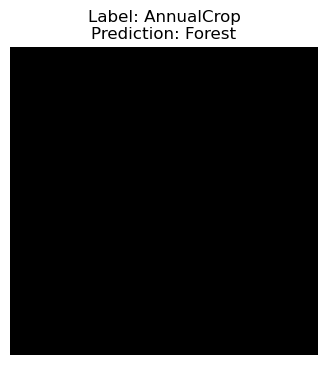

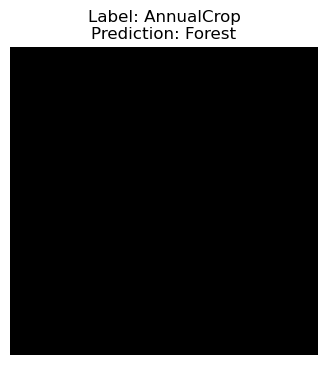

In [8]:
trainer.fit(model=task, datamodule=datamodule)